In [2]:
import xarray as xr
import cmocean
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from universal import *

In [3]:
ds = xr.open_mfdataset('../data/processed/regridded/CESM1.2_CAM5.*.mean.3x2.nc')
grid = xr.open_dataset('../data/processed/regridded/grid_3x2_pressure.nc')

In [4]:
experiments = ['piControl','deepmip_sens_1xCO2','deepmip_stand_3xCO2','deepmip_stand_6xCO2','deepmip_sens_9xCO2']

In [6]:
ds['PmE'] = ds['pr']-ds['evspsbl']

In [10]:
variable = 'PmE'
with ProgressBar():
    da = ds[variable].mean('time').compute()

[########################################] | 100% Completed | 106.12 ms


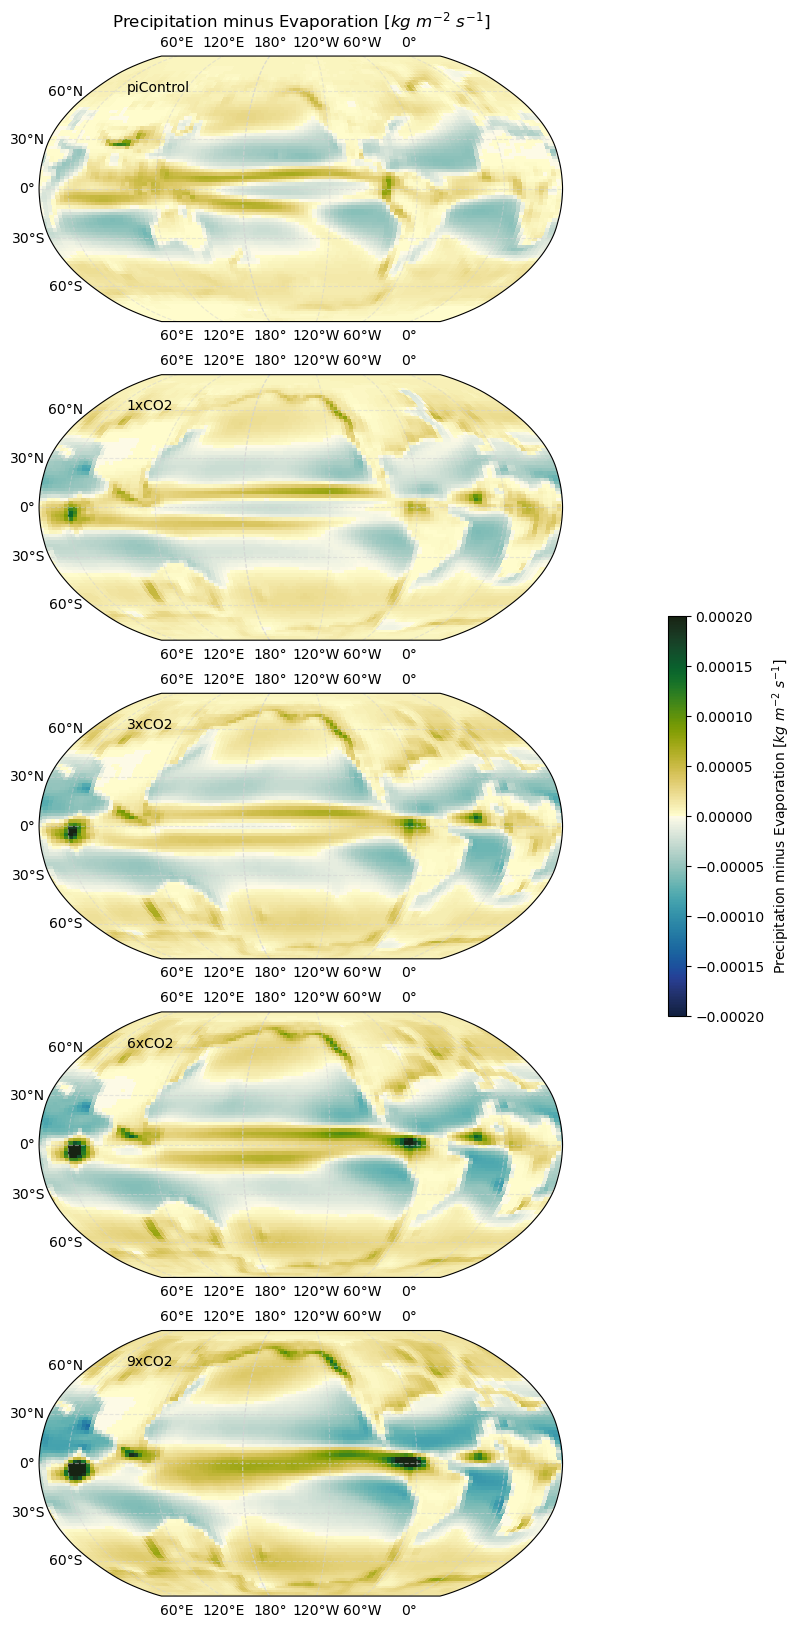

In [14]:
if variable=='pr':
    clims = [0,4e-4]
    longname = 'Precipitation [$kg\ m^{-2}\ s^{-1}$]'
    cmap = cmocean.cm.rain
elif variable=='evspsbl':
    longname = 'Evaporation including sublimation and transpiration [$kg\ m^{-2}\ s^{-1}$]'
    clims = [0,2e-4]
    cmap = cmocean.cm.rain
elif variable=='PmE':
    longname = 'Precipitation minus Evaporation [$kg\ m^{-2}\ s^{-1}$]'
    clims = [-2e-4,2e-4]
    cmap = cmocean.cm.delta
    
cmap.set_bad(color='darkgrey',alpha=0)
ne = len(experiments)
fig,axarr = plt.subplots(figsize=(9,4*ne),nrows=ne,subplot_kw={'projection':ccrs.Robinson(central_longitude=220)})
for i,experiment in enumerate(experiments):
    axnow = axarr[i]
    danow = da.sel(experiment=experiment)
    im = axnow.pcolormesh(danow['x'],danow['y'],danow,transform=ccrs.PlateCarree(),cmap=cmap)
    axnow.text(70,60,experiment.split('_')[-1],color='k',ha='left',fontweight=12,transform=ccrs.PlateCarree())
    im.set_clim(clims)
    axnow.gridlines(draw_labels=True,color='lightgrey',linestyle='--',alpha=0.5)
    if i==0:
        axnow.set_title(longname)
axc = fig.add_axes([0.92,0.4,0.02,0.2])
cb = fig.colorbar(im,cax=axc)
cb.set_label(longname)

In [53]:
variable = 'PmE'
processing = 'zonalmean'
if processing=='zonalmean':
    units = '$kg\ m^{-2}\ s^{-1}$'
    with ProgressBar():
            da = ds[variable].weighted(grid['area'].fillna(0)).mean('x').mean('time').compute()
elif processing=='zonalintegral':
    units = '$kg\ s^{-1}$'
    with ProgressBar():
            da = ds[variable].weighted(grid['area'].fillna(0)).sum('x').mean('time').compute()

[########################################] | 100% Completed | 106.64 ms


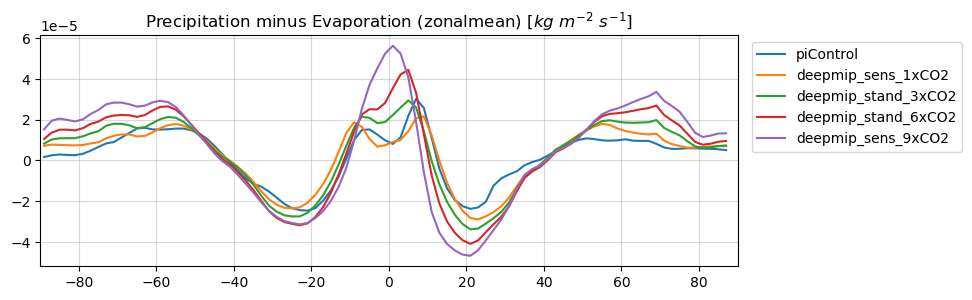

In [55]:
if variable=='pr':
    clims = [0,4e-4]
    longname = 'Precipitation ('+processing+') ['+units+']'
elif variable=='evspsbl':
    longname = 'Evaporation ('+processing+') ['+units+']'
    clims = [0,2e-4]
elif variable=='PmE':
    longname = 'Precipitation minus Evaporation ('+processing+') ['+units+']'
    clims = [-2e-4,2e-4]
    
experiments = ['piControl','deepmip_sens_1xCO2','deepmip_stand_3xCO2','deepmip_stand_6xCO2','deepmip_sens_9xCO2']

fig,ax = plt.subplots(figsize=(9,3))
for i,experiment in enumerate(experiments):
    danow = da.sel(experiment=experiment)
    ax.plot(danow['y'],danow,label=experiment,color=colors[experiment])
ax.legend(loc='upper left',bbox_to_anchor=(1.01,1))
ax.set_title(longname)
ax.set_xlim(-90,90)
# ax.set_ylim(clims)
ax.grid(alpha=0.5)

# Mean volume flux from hydrological cycle

In [58]:
experiments = ['deepmip_sens_1xCO2','deepmip_stand_3xCO2','deepmip_stand_6xCO2','deepmip_sens_9xCO2']

In [60]:
yarray = ds['y']*xr.ones_like(ds['x']) # broadcast latitude
latbounds = np.array([[-90,-50],[-50,-10],[-10,10],[10,50],[50,90]])
tmp = []
latstr = []
for i in range(len(latbounds)):
    lats = latbounds[i,:]
    latstr.append(str(lats[0])+' to '+str(lats[1]))
    cond = (yarray>=lats[0]) & (yarray<lats[1])
    dsnow = ds.where(cond)
    gridnow = grid.where(cond)
    tmp.append(dsnow.weighted(gridnow['area'].fillna(0)).mean(['x','y']))
dslats = xr.concat(tmp,dim='latbounds').assign_coords({'latbounds':latstr})

In [62]:
with ProgressBar():
    dslatsanom = (dslats-dslats.sel(experiment='deepmip_sens_1xCO2')).mean('time').compute()
    dslats = dslats.mean('time').compute()

[########################################] | 100% Completed | 848.73 ms
[########################################] | 100% Completed | 741.08 ms


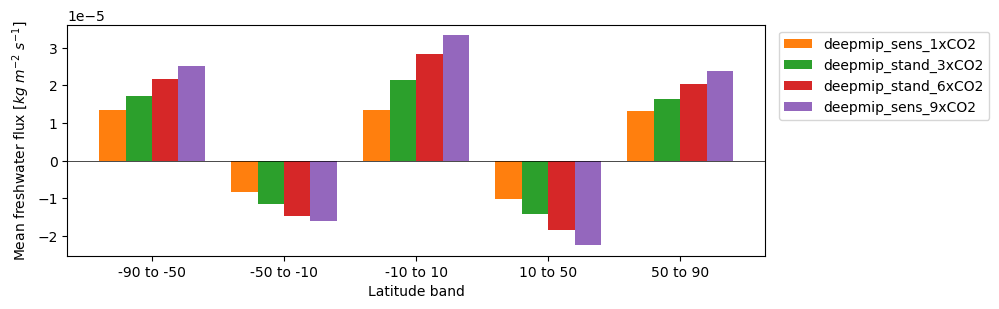

In [68]:
width = 0.2
fig,ax = plt.subplots(figsize = (9,3))
# colors = [name for name,code in mpl.colors.TABLEAU_COLORS.items()]
handles_exp = []
for i,lats in enumerate(dslats['latbounds']):
    danow = dslats['PmE'].sel(latbounds=lats)
    for j,experiment in enumerate(experiments):
        da = danow.sel(experiment=experiment)
        offset = -width*len(experiments)/2+width*(j+0.5)
        h = ax.bar(i+offset,da,width=width,bottom=0,color=colors[experiment],label=experiment)
        if i==0:
            handles_exp.append(h)
ax.set_xticks(np.arange(len(dslats['latbounds'])))
ax.set_xticklabels(dslats['latbounds'].values);
l = ax.legend(handles=handles_exp,loc='upper left',bbox_to_anchor=(1.01,1))
ax.set_ylabel('Mean freshwater flux [$kg\ m^{-2}\ s^{-1}$]')
ax.set_xlabel('Latitude band')
ax.axhline(0,color='k',linewidth=0.5)

# Integrated volume flux from hydrological cycle

In [71]:
experiments = ['deepmip_sens_1xCO2','deepmip_stand_3xCO2','deepmip_stand_6xCO2','deepmip_sens_9xCO2']

In [73]:
yarray = ds['y']*xr.ones_like(ds['x']) # broadcast latitude
latbounds = np.array([[-90,-50],[-50,-10],[-10,10],[10,50],[50,90]])
tmp = []
latstr = []
for i in range(len(latbounds)):
    lats = latbounds[i,:]
    latstr.append(str(lats[0])+' to '+str(lats[1]))
    cond = (yarray>=lats[0]) & (yarray<lats[1])
    dsnow = ds.where(cond)
    gridnow = grid.where(cond)
    tmp.append(dsnow.weighted(gridnow['area'].fillna(0)).sum(['x','y']))
dslats = xr.concat(tmp,dim='latbounds').assign_coords({'latbounds':latstr})

In [75]:
with ProgressBar():
    dslatsanom = (dslats-dslats.sel(experiment='deepmip_sens_1xCO2')).mean('time').compute()
    dslats = dslats.mean('time').compute()

[########################################] | 100% Completed | 1.34 sms
[########################################] | 100% Completed | 751.38 ms


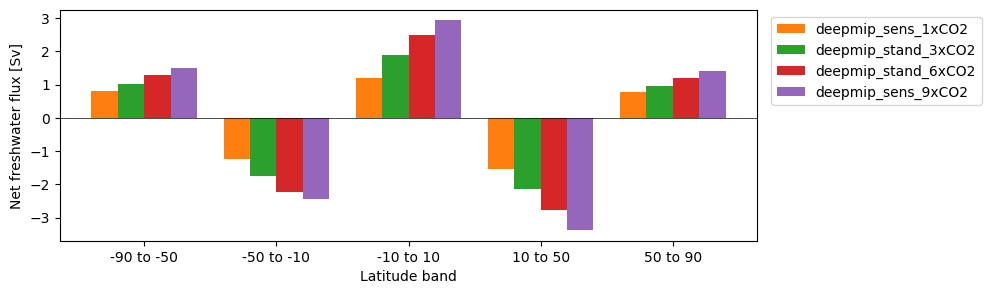

In [77]:
width = 0.2
fig,ax = plt.subplots(figsize = (9,3))
# colors = [name for name,code in mpl.colors.TABLEAU_COLORS.items()]
handles_exp = []
for i,lats in enumerate(dslats['latbounds']):
    danow = dslats['PmE'].sel(latbounds=lats)
    for j,experiment in enumerate(experiments):
        da = danow.sel(experiment=experiment)
        offset = -width*len(experiments)/2+width*(j+0.5)
        h = ax.bar(i+offset,da*1e-9,width=width,bottom=0,color=colors[experiment],label=experiment)
        if i==0:
            handles_exp.append(h)
ax.set_xticks(np.arange(len(dslats['latbounds'])))
ax.set_xticklabels(dslats['latbounds'].values);
l = ax.legend(handles=handles_exp,loc='upper left',bbox_to_anchor=(1.01,1))
ax.set_ylabel('Net freshwater flux [Sv]')
ax.set_xlabel('Latitude band')
ax.axhline(0,color='k',linewidth=0.5)